In [39]:
import networkx as nx
import matplotlib.pyplot as plt

def parse_regulation_file(file_path):
    # Create a directed graph to represent the network
    G = nx.DiGraph()

    # Open and read the file line by line
    with open(file_path, 'r') as file:
        current_regulator = None  # Initialize the current regulator variable
        for line in file:
            # Ignore lines starting with '#' or that are empty
            if line.startswith('#') or not line.strip():
                continue

            # Remove trailing whitespace from the line
            line = line.rstrip()

            # Check if a line does not start with an indent and also ends with an asterisk
            if not line.startswith('  ') and line.endswith('*'):
                # Remove the asterisk and set that as the current_regulator
                current_regulator = line[:-1].strip()
                # Make first letter uppercase
                current_regulator = current_regulator[0].upper() + current_regulator[1:]
                # If the current regulator is not already in the graph, add it
                if current_regulator not in G:
                    G.add_node(current_regulator)
            elif current_regulator and line.startswith('  '):
                # Process the regulatees
                regulatees = line.strip().split()
                for regulatee in regulatees:
                    # Determine the polarity and adjust slicing accordingly
                    if regulatee.startswith('+/-'):
                        polarity = '+/-'
                        gene = regulatee[3:]
                    elif regulatee.startswith('+') or regulatee.startswith('-'):
                        polarity = regulatee[0]
                        gene = regulatee[1:]
                    else:
                        polarity = None
                        gene = regulatee

                    # Remove the trailing asterisk if present
                    gene = gene.rstrip('*')
                    # Make first letter uppercase
                    gene = gene[0].upper() + gene[1:]

                    # If the regulatee is not in the graph, add it
                    if gene not in G:
                        G.add_node(gene)
                    # Add an edge between the current_regulator and the regulatee with the polarity as an attribute
                    G.add_edge(current_regulator, gene, polarity=polarity)
    return G


def draw_network(G):
    pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm
    nx.draw(G, pos, with_labels=True, node_size=2, node_color='lightblue', edge_color='gray')
    edge_labels = nx.get_edge_attributes(G, 'polarity')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()


def get_subgraph_from_nodes(G, node_list, descendants_only=False):
    # Initialize a set for all the nodes in the subgraph
    subgraph_nodes = set()

    # For each node in the list, find all descendants and ancestors
    for node in node_list:
        if node in G:
            subgraph_nodes.add(node)  # add single element 
            descendants = nx.descendants(G, node)
            if len(descendants) == 1:
                subgraph_nodes.add(descendants)
            else:
                subgraph_nodes.update(descendants)
            if not descendants_only:
                for desc in descendants:
                    ancestors = nx.ancestors(G, desc)
                    if len(ancestors) == 1:
                        subgraph_nodes.add(ancestors)
                    else:
                        subgraph_nodes.update(ancestors)
        else:
            print(f'{node} not found in graph.')

    # Create the subgraph from the full graph using the nodes in the set
    subgraph = G.subgraph(subgraph_nodes)
    return subgraph


def process_graph(full_network, node_list, descendants_only=False, full_network_name="ecoli", print_results=True, save_results=True, plot_subgraph=False):
    
    subgraph = get_subgraph_from_nodes(full_network, node_list, descendants_only)

    if print_results:
        print(f'full graph network: n nodes: {len(full_network.nodes())}, n edges: {len(full_network.edges())}')
        if descendants_only:
            print(f'subgraph network for {node_list} with descendants only: n nodes: {len(subgraph.nodes())}, n edges: {len(subgraph.edges())}')
        else:
            print(f'subgraph network for {node_list}: n nodes: {len(subgraph.nodes())}, n edges: {len(subgraph.edges())}')
        print('\n')

    if save_results:
        gene_string = '_'.join(node_list)
        if descendants_only:
            gene_string += '_descendants_only'
        output_filename = f"{full_network_name}_subgraph_{gene_string}"
        nx.write_gexf(subgraph, f"{output_filename}.gexf")
        nx.write_adjlist(subgraph, f"{output_filename}.txt")

    if plot_subgraph:
        draw_network(subgraph)
    
    return subgraph


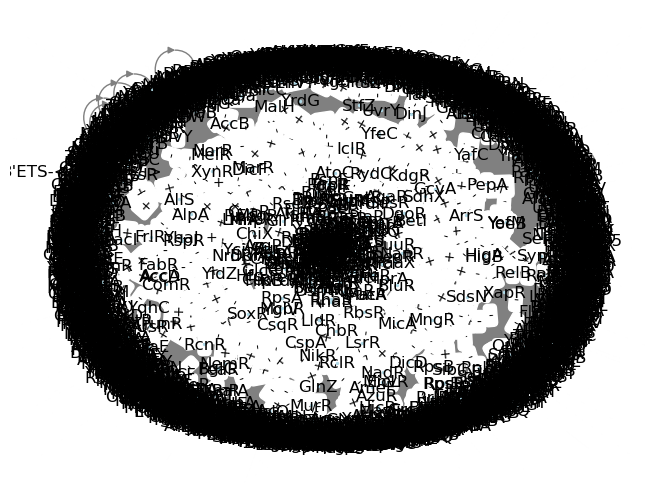

In [40]:
# Load ecoli GRN text file and display it
file_path = './ECOLI-regulatory-network.txt'  
ecoli_network = parse_regulation_file(file_path)
draw_network(ecoli_network)

full graph network: n nodes: 3042, n edges: 9678
subgraph network for ['TyrR', 'FadR', 'LacI']: n nodes: 152, n edges: 727




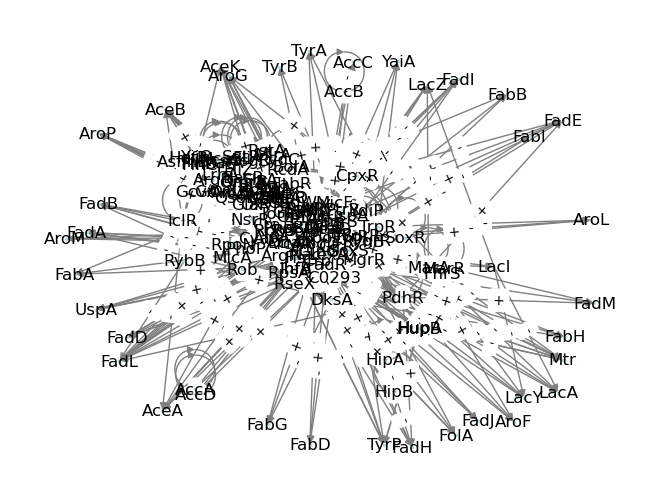

In [41]:
# get subgraph using multiple TFs using both descendants and their ancestors
gene_list = ["TyrR", "FadR", "LacI"] 
subgraph = process_graph(ecoli_network, gene_list, descendants_only=False, full_network_name="ecoli", print_results=True, save_results=True, plot_subgraph=True)

full graph network: n nodes: 3042, n edges: 9678
subgraph network for ['TyrR', 'FadR', 'LacI'] with descendants only: n nodes: 41, n edges: 47




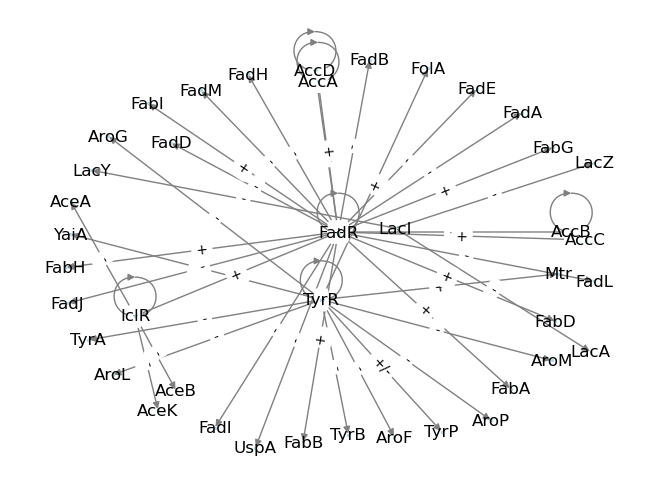

In [42]:
# get subgraph using multiple TFs using only descendants 
gene_list = ["TyrR", "FadR", "LacI"] 
subgraph = process_graph(ecoli_network, gene_list, descendants_only=True, full_network_name="ecoli", print_results=True, save_results=True, plot_subgraph=True)

full graph network: n nodes: 3042, n edges: 9678
subgraph network for ['TyrR']: n nodes: 118, n edges: 574




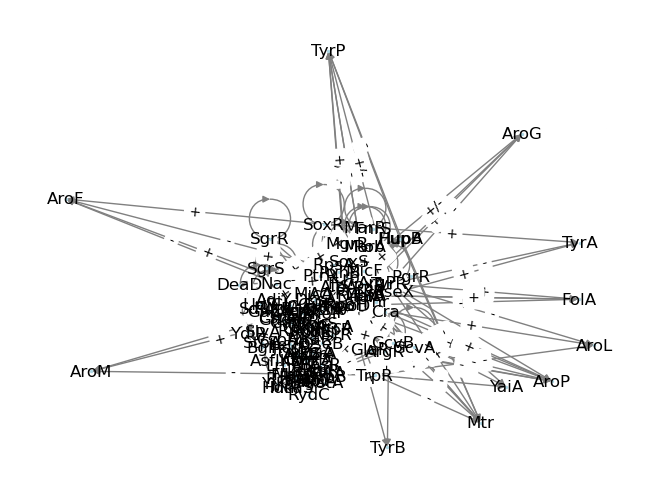

full graph network: n nodes: 3042, n edges: 9678
subgraph network for ['FadR']: n nodes: 134, n edges: 655




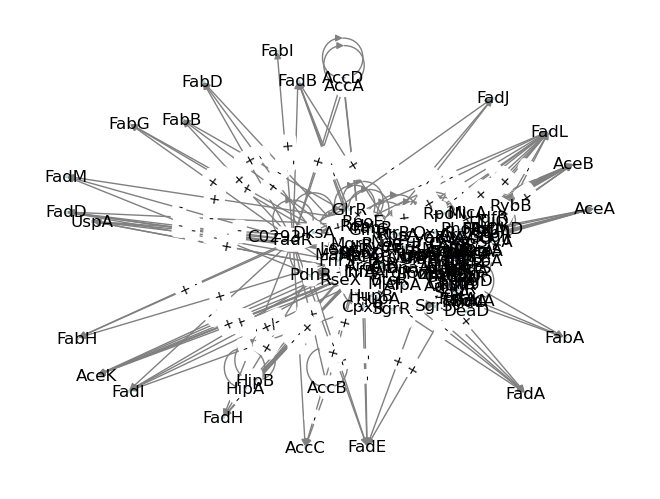

full graph network: n nodes: 3042, n edges: 9678
subgraph network for ['LacI']: n nodes: 108, n edges: 536




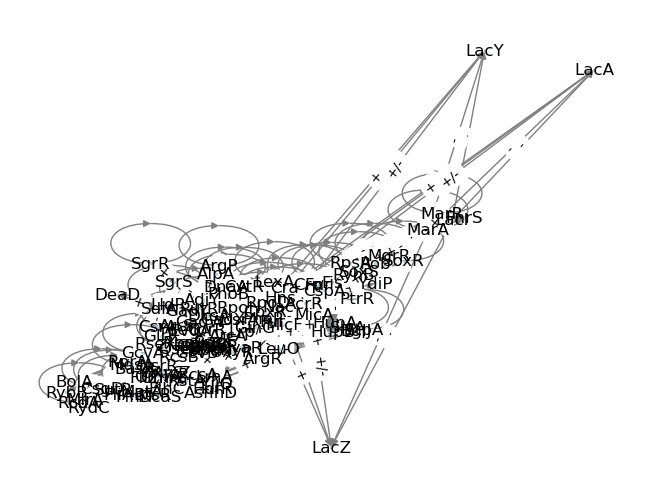

In [44]:
# get subgraph from a single TF and its descendants and their ancestors
for gene in gene_list:
    subgraph = process_graph(ecoli_network, [gene], descendants_only=False, full_network_name="ecoli", print_results=True, save_results=True, plot_subgraph=True)

full graph network: n nodes: 3042, n edges: 9678
subgraph network for ['TyrR'] with descendants only: n nodes: 12, n edges: 12




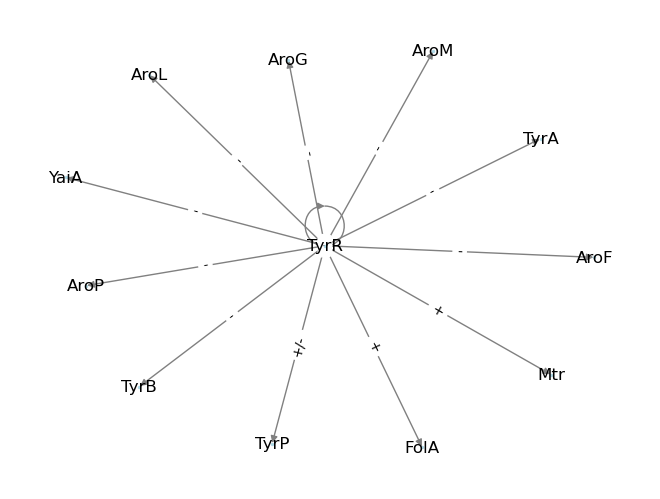

full graph network: n nodes: 3042, n edges: 9678
subgraph network for ['FadR'] with descendants only: n nodes: 25, n edges: 32




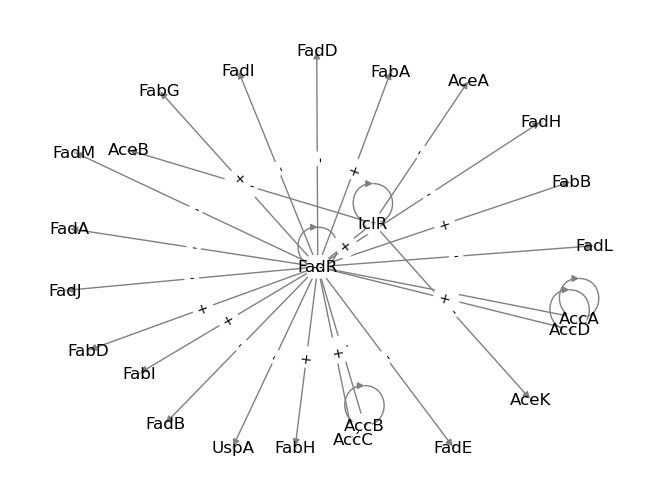

full graph network: n nodes: 3042, n edges: 9678
subgraph network for ['LacI'] with descendants only: n nodes: 4, n edges: 3




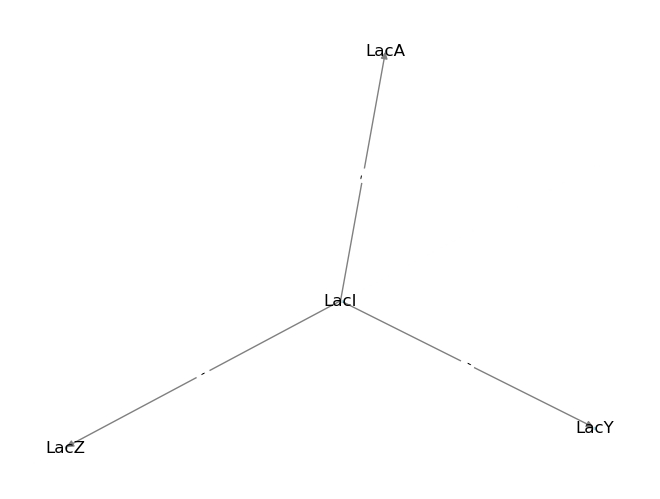

In [45]:
# get subgraph from a single TF and only its descendants
for gene in gene_list:
    subgraph = process_graph(ecoli_network, [gene], descendants_only=True, full_network_name="ecoli", print_results=True, save_results=True, plot_subgraph=True)